# GraphRAG Implementation

The concept of GraphRAG was first introduced in the research paper titled **“From Local to Global: A Graph RAG Approach to Query-Focused Summarization,”** by Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, Steven Truitt, Jonathan Larson, published in April 2024.  

This paper addresses the limitations of traditional Retrieval-Augmented Generation (RAG) systems when handling global queries over extensive text corpora. The authors propose a novel approach that integrates large language models (LLMs) with graph-based text indexing to construct an entity knowledge graph from source documents. By generating community summaries for groups of related entities, the system can produce comprehensive and diverse responses to broad, sensemaking questions. Evaluations demonstrate that this Graph RAG method significantly outperforms baseline RAG models in both comprehensiveness and diversity of answers, particularly for large datasets.

The goal of this project is to experiment with a Graph-based Retrieval-Augmented Generation (GraphRAG) pipeline to analyze and query scientific documents. The **GSAP-NER** corpus consists of 100 manually annotated full-text scientific publications, focusing on machine learning models and datasets. This resource is valuable for extracting scholarly entities related to machine learning and available at [this link](https://arxiv.org/abs/2311.09860).

#### Graph-Based Retrieval-Augmented Generation (GraphRAG) Pipeline

**1.  Data Preprocessing:**
* Load scientific documents.
  
**2.  Entity Extraction**
* Identify key entities (titles, abstracts in this experiment) from documents.
* Store extracted entities for future graph construction and enhanced search.

**3.  Graph Construction**
* Represent documents as nodes and use SBERT embeddings to compute text similarity.
* Add edges between similar documents based on a predefined similarity threshold.
* Build the Graph based on nodes and edges.

**4.  Clustering for Community Detection**
* Apply the Louvain algorithm to group similar documents into meaningful clusters.

**5.  Summarization of Clusters**
* Generate concise summaries for each cluster using a GPT model.
* Store these summaries to enhance search relevance.

**6.  Graph Visualization**
* Display the document similarity graph with different colors for each cluster.

**7.  Query Processing (Retrieval)**
*  Convert the user query into an SBERT embedding and retrieve the most relevant documents.  Use cosine similarity to rank retrieved documents based on relevance.  The response in this case provides only ranking for the relevance of the documents.
*  Provide retrieved documents as context to GPT to generate a natural language response.







## References

1. Research Paper **“From Local to Global: A Graph RAG Approach to Query-Focused Summarization”** by Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, Steven Truitt, Jonathan Larson, published in April 2024 and available at this [link.](https://arxiv.org/abs/2404.16130?utm_source=chatgpt.com)

2. **Dataset:** The GSAP-NER corpus consists of 100 manually annotated full-text scientific publications, focusing on machine learning models and datasets. This resource is available at [this link](https://arxiv.org/abs/2311.09860).  
Raw data is available at [this link.](https://raw.githubusercontent.com/ottowg/gsap-ner/emnlp_submission/data/raw_publications/)

### Setup

In [ ]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "your-path-here"

In [ ]:
%%capture
!pip install spacy networkx numpy matplotlib wordcloud tqdm leidenalg igraph

In [ ]:
%%capture
!pip install node2vec

In [ ]:
%%capture
! pip install python-louvain

In [ ]:
import os
import requests
import json
import spacy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import openai
from openai import OpenAI
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import leidenalg as la
from leidenalg import find_partition
import igraph as ig
import pprint
import pickle
import community.community_louvain as community_louvain
from sklearn.cluster import KMeans
from node2vec import Node2Vec  # Requires `pip install node2vec`
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import community.community_louvain as community_louvain
import textwrap

In [ ]:
# Set OpenAI API key

os.environ["OPENAI_API_KEY"] = "your-openai-api-key-here"

### Load Data

In [ ]:
# Base dataset URL
base_url = "https://raw.githubusercontent.com/ottowg/gsap-ner/emnlp_submission/data/raw_publications/"

files = [
    "00001_1911_02116.json", "00002_1810_04805.json", "00003_2103_00020.json",
    "00004_1908_04913.json", "00005_1806_02847.json", "00006_1907_11692.json",
    "00007_1910_01108.json", "00008_1910_13461.json", "00009_1810_09305.json",
    "00010_1904_06472.json", "00011_1704_05179.json", "00012_2102_07033.json",
    "00013_2104_08727.json", "00014_2010_12421.json", "00015_1910_09700.json",
    "00016_2106_09462.json", "00017_1905_10044.json", "00018_1810_12885.json",
    "00019_1808_09121.json", "00020_1606_05250.json"
]

In [ ]:
def download_data():
    os.makedirs("data", exist_ok=True)
    for file_name in files:
        file_path = f"data/{file_name}"
        if not os.path.exists(file_path):  # Avoid re-downloading
            response = requests.get(base_url + file_name)
            if response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(response.content)
            else:
                print(f"Failed to download {file_name}")

In [ ]:
def load_data(sample_size=10):  # Load only first 10 files
    data = []
    for file_name in files[:sample_size]:  # Limit number of files
        file_path = f"data/{file_name}"
        if os.path.exists(file_path):
            with open(file_path, "r") as f:
                try:
                    file_data = json.load(f)  # Ensure proper JSON loading
                    if isinstance(file_data, dict):  # If the file contains a single JSON object
                        data.append(file_data)
                    elif isinstance(file_data, list):  # If the file contains a list of JSON objects
                        data.extend(file_data)
                except json.JSONDecodeError as e:
                    print(f"Error loading {file_name}: {e}")
    return data

### Extract Entities

In [ ]:
# Load NLP model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_entities(text):
    doc = nlp(text)
    return list(set([(ent.text, ent.label_) for ent in doc.ents]))

### Summarize Text

In [ ]:
# Cache file path
CACHE_FILE = "summary_cache.pkl"

# Load existing cache if available
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "rb") as f:
        summary_cache = pickle.load(f)
else:
    summary_cache = {}

def summarize_text(text, max_length=500):
    """Summarize text efficiently by limiting length and caching results."""

    # Check if summary already exists in cache
    if text in summary_cache:
        return summary_cache[text]

    # Limit input text length
    text = text[:max_length]

    try:
        client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Summarize the following text."},
                {"role": "user", "content": text}
            ],
            max_tokens=100  # Reduce token usage
        )
        summary = response.choices[0].message.content

        # Cache the result
        summary_cache[text] = summary
        with open(CACHE_FILE, "wb") as f:
            pickle.dump(summary_cache, f)

        return summary

    except openai.OpenAIError as e:
        print(f"OpenAI API Error: {e}")
        return "Summary unavailable due to API limits."

### Build Graph

In [ ]:
# Download data before loading it
download_data()
data = load_data(sample_size=10)

In [ ]:
pp = pprint.PrettyPrinter(depth=2, width=200)  # Customize depth/width for readability
pp.pprint(data[0])

{'annotations': {'Abstract': [...],
                 'Div': [...],
                 'Footnote': [...],
                 'Head': [...],
                 'Paragraph': [...],
                 'ReferenceString': [...],
                 'ReferenceToBib': [...],
                 'ReferenceToFigure': [...],
                 'ReferenceToFootnote': [...],
                 'ReferenceToFormula': [...],
                 'ReferenceToTable': [...],
                 'SectionFootnote': [...],
                 'SectionHeader': [...],
                 'SectionMain': [...],
                 'SectionReference': [...],
                 'Sentence': [...]},
 'text': 'Unsupervised Cross-lingual Representation Learning at Scale\n'
         '\n'
         'Abstract:\n'
         'This paper shows that pretraining multilingual language models at scale leads to significant performance gains for a wide range of crosslingual transfer tasks. We train a Transformerbased '
         'masked language model on one hundred 

In [ ]:
# Verify data
print(f"Data Type: {type(data)}")  # Check overall data type
print(f"Sample Data Length: {len(data)}")  # Check how many elements are inside
if len(data) > 0:
    print(f"Type of First Element: {type(data[0])}")  # Type of first item
    print(f"First Element Content: {data[0]}")  # Show first element

Data Type: <class 'list'>
Sample Data Length: 10
Type of First Element: <class 'dict'>
First Element Content: {'text': "Unsupervised Cross-lingual Representation Learning at Scale\n\nAbstract:\nThis paper shows that pretraining multilingual language models at scale leads to significant performance gains for a wide range of crosslingual transfer tasks. We train a Transformerbased masked language model on one hundred languages, using more than two terabytes of filtered CommonCrawl data. Our model, dubbed XLM-R, significantly outperforms multilingual BERT (mBERT) on a variety of cross-lingual benchmarks, including +14.6% average accuracy on XNLI, +13% average F1 score on MLQA, and +2.4% F1 score on NER. XLM-R performs particularly well on low-resource languages, improving 15.7% in XNLI accuracy for Swahili and 11.4% for Urdu over previous XLM models. We also present a detailed empirical analysis of the key factors that are required to achieve these gains, including the trade-offs between 

In [ ]:
# List All Keys in the Document
print("Available keys:", list(first_doc.keys()))

Available keys: ['text', 'annotations']


In [ ]:
# Build Graph with Only Document Nodes
G = nx.Graph()

for idx, document in enumerate(tqdm(data, desc="Processing Documents")):
    if not isinstance(document, dict):
        print(f"Skipping document {idx} (not a dictionary)")
        continue

    doc_id = f"doc_{idx}"
    full_text = document.get("text", "").strip()

    # Extract title as the first line
    title_lines = full_text.split("\n", 1)
    title = title_lines[0] if title_lines else "No Title"
    text = title_lines[1].strip() if len(title_lines) > 1 else ""  # Remove title from text

    # Add document node to the graph
    G.add_node(doc_id, label="document", title=title, text=text)
    print(f"Added node: {doc_id}, Title: {title[:50]}")  # Debugging output

Processing Documents: 100%|██████████| 10/10 [00:00<00:00, 13797.05it/s]

Added node: doc_0, Title: Unsupervised Cross-lingual Representation Learning
Added node: doc_1, Title: BERT: Pre-training of Deep Bidirectional Transform
Added node: doc_2, Title: Learning Transferable Visual Models From Natural L
Added node: doc_3, Title: FairFace: Face Attribute Dataset for Balanced Race
Added node: doc_4, Title: A Simple Method for Commonsense Reasoning
Added node: doc_5, Title: RoBERTa: A Robustly Optimized BERT Pretraining App
Added node: doc_6, Title: DistilBERT, a distilled version of BERT: smaller, 
Added node: doc_7, Title: Abstract:
Added node: doc_8, Title: WikiHow: A Large Scale Text Summarization Dataset
Added node: doc_9, Title: A Repository of Conversational Datasets github.com


In [ ]:
# Verify structure of nodes and edges
print("\n Sample Nodes (First 5):")
for node, data in list(G.nodes(data=True))[:5]:
    print(f"- {node} ({data.get('label', 'No Label')})")
    if 'title' in data:
        print(f" Title: {data['title'][:100]}...")  # Limit title to 100 chars
    if 'text' in data:
        print(f" Text: {data['text'][:100]}...")  # Limit text preview to 100 chars
    print("-" * 50)

print("\nSample Edges (First 10):")
for source, target, data in list(G.edges(data=True))[:10]:
    print(f"- {source} {target} ({data.get('relationship', 'No Relation')})")


 Sample Nodes (First 5):
- doc_0 (document)
 Title: Unsupervised Cross-lingual Representation Learning at Scale...
 Text: Abstract:
This paper shows that pretraining multilingual language models at scale leads to significa...
--------------------------------------------------
- doc_1 (document)
 Title: BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding...
 Text: Abstract:
We introduce a new language representation model called BERT, which stands for Bidirection...
--------------------------------------------------
- doc_2 (document)
 Title: Learning Transferable Visual Models From Natural Language Supervision...
 Text: Abstract:
State-of-the-art computer vision systems are trained to predict a fixed set of predetermin...
--------------------------------------------------
- doc_3 (document)
 Title: FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age...
 Text: Abstract:
Existing public face datasets are strongly biased toward Caucasian faces

In [ ]:
print(f"Total edges in graph: {G.number_of_edges()}")

Total edges in graph: 0


In [ ]:
# Building edges in the graph

# Generate embeddings for each document
model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight model for efficiency
doc_ids = list(G.nodes())  # Get document nodes
texts = [G.nodes[doc]["text"] for doc in doc_ids]  # Extract texts

embeddings = model.encode(texts, convert_to_numpy=True)  # Generate embeddings

# Compute similarity between document pairs
similarity_matrix = cosine_similarity(embeddings)

# Define a similarity threshold (adjust as needed)
similarity_threshold = 0.51  # Only keep strong connections

# Add edges to the graph for similar documents
for i in range(len(doc_ids)):
    for j in range(i + 1, len(doc_ids)):  # Avoid duplicate pairs
        similarity = similarity_matrix[i, j]
        if similarity >= similarity_threshold:
            G.add_edge(doc_ids[i], doc_ids[j], weight=similarity)  # Add edge with similarity score

# Print number of edges created
print(f"Total edges added: {G.number_of_edges()}")

Total edges added: 22


In [ ]:
# Print similarity scores to check the range
print(f"Max similarity: {np.max(similarity_matrix)}")
print(f"Min similarity: {np.min(similarity_matrix)}")
print(f"Mean similarity: {np.mean(similarity_matrix)}")

Max similarity: 1.0000003576278687
Min similarity: 0.2626951336860657
Mean similarity: 0.5298933386802673


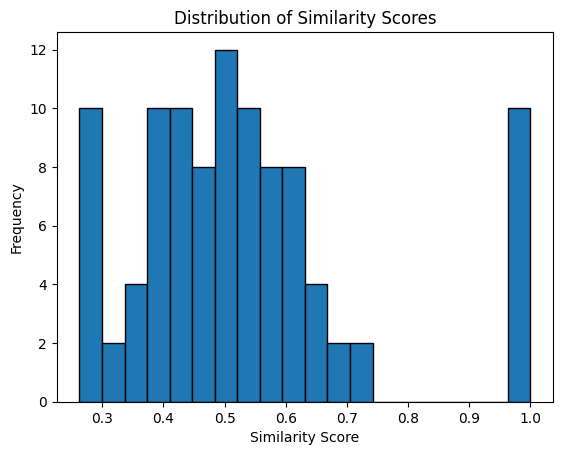

In [ ]:
# Plot distribution of similarity scores to find the best similarity_threshold

plt.hist(similarity_matrix.flatten(), bins=20, edgecolor='black')
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.show()

In [ ]:
# Louvain Clustering

partition = community_louvain.best_partition(G)  # Detect clusters

# Organize clusters
clusters = {i: [] for i in set(partition.values())}
for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

print(f"Total clusters detected: {len(clusters)}")

Total clusters detected: 3


In [ ]:
# Check Cluster Sizes
for cluster_id, nodes in clusters.items():
    print(f"Cluster {cluster_id}: {len(nodes)} documents")

Cluster 0: 4 documents
Cluster 1: 5 documents
Cluster 2: 1 documents


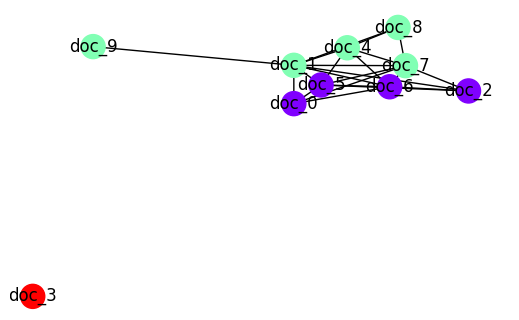

In [ ]:
# Visualize the Clusters
pos = nx.spring_layout(G)  # Position nodes
plt.figure(figsize=(5,3))
nx.draw(G, pos, with_labels=True, node_color=list(partition.values()), cmap=plt.cm.rainbow)
plt.show()

In [ ]:
# Summarize Each Cluster
for cluster_id, nodes in clusters.items():
    print("\n" + "=" * 60)  # Separator for clarity
    print(f" Cluster {cluster_id} - {len(nodes)} documents")
    print("=" * 60)

    # Combine all text in the cluster
    combined_text = " ".join([G.nodes[n]["text"] for n in nodes if "text" in G.nodes[n]])

    # Generate a summary
    summary = summarize_text(combined_text, max_length=300)  # Adjust max_length if needed

    # Print summary in a readable way
    print(f" Summary:\n{textwrap.fill(summary, width=80)}")  # Wrap text at 80 characters


 Cluster 0 - 4 documents
 Summary:
This paper demonstrates that training large multilingual language models
improves performance on various crosslingual tasks. The researchers pretrain a
Transformer-based masked language model on 100 languages, using a substantial
amount of data from CommonCrawl.

 Cluster 1 - 5 documents
 Summary:
BERT, a new language representation model, stands for Bidirectional Encoder
Representations from Transformers. Unlike existing models, BERT is specially
designed for pretraining deep bidirectional representations.

 Cluster 2 - 1 documents
 Summary:
The text discusses how current public face datasets are biased towards Caucasian
faces while other races, such as Latino faces, are underrepresented. This bias
can result in inconsistent model accuracy, restrict the usefulness of face
analytic systems for non-White race groups, and have negative implications for
research.


In [ ]:
 # Summarize Communities
community_summaries = {}

for cluster_id, nodes in tqdm(clusters.items(), desc="Summarizing Communities"):
    combined_text = " ".join([G.nodes[n].get("text", "") for n in nodes if "text" in G.nodes[n]])

    # Skip empty clusters
    if not combined_text.strip():
        print(f" Skipping Cluster {cluster_id}: No content to summarize.")
        continue

    # Generate summary (adjust max_length as needed)
    summary = summarize_text(combined_text, max_length=300)

    # Store summary
    community_summaries[cluster_id] = summary

# Display Summaries
print("\n" + "=" * 80)
print(" **Community Summaries**")
print("=" * 80)

for cluster_id, summary in community_summaries.items():
    print("\n" + "-" * 80)
    print(f" **Cluster {cluster_id}** - {len(clusters[cluster_id])} documents")
    print("-" * 80)
    print(f" Summary:\n{textwrap.fill(summary, width=80)}")  # Wrap text for better readability

Summarizing Communities: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


 **Community Summaries**

--------------------------------------------------------------------------------
 **Cluster 0** - 4 documents
--------------------------------------------------------------------------------
 Summary:
The paper demonstrates that training multilingual language models on a large
scale provides substantial improvements for various crosslingual transfer tasks.
The researchers utilize a Transformer-based masked language model trained on one
hundred languages using over two terabytes of filtered CommonCrawl data.

--------------------------------------------------------------------------------
 **Cluster 1** - 5 documents
--------------------------------------------------------------------------------
 Summary:
The text introduces a new language representation model called BERT, short for
Bidirectional Encoder Representations from Transformers. Unlike previous models,
BERT is specifically designed to pretrain deep bidirectional representations.

-------------------

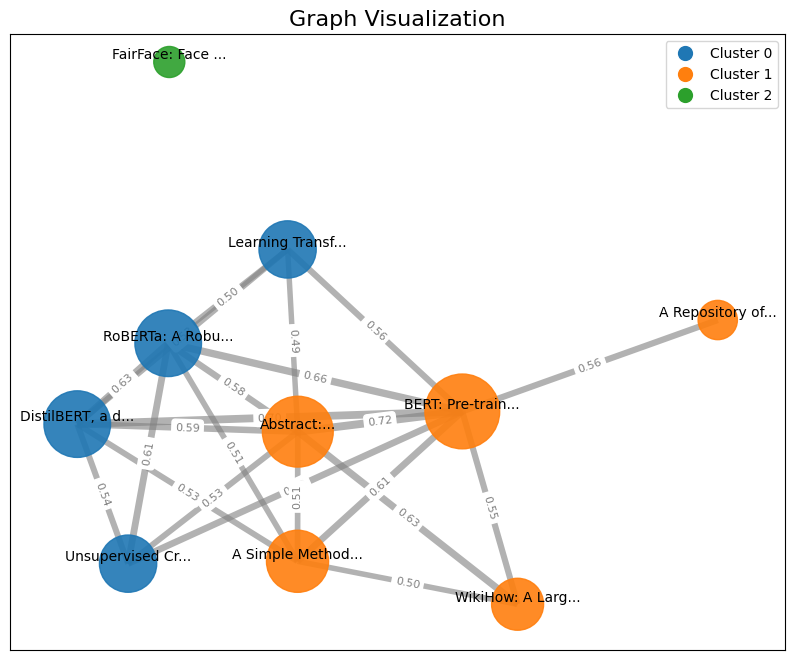

In [ ]:
# Graph Visualization

# Define colors for different clusters using the updated colormap syntax
num_clusters = len(set(partition.values()))
cluster_colors = {cid: plt.colormaps["tab10"](i % 10) for i, cid in enumerate(set(partition.values()))}

# Assign colors to nodes based on cluster
node_colors = [cluster_colors[partition[node]] for node in G.nodes]

# Adaptive node size (more connected nodes appear bigger)
node_sizes = [len(list(G.neighbors(node))) * 300 + 500 for node in G.nodes]

# Define edge weights (thicker edges for higher similarity)
edge_weights = [G[u][v]["weight"] * 8 for u, v in G.edges]

# Extract node labels (shorter titles for better readability)
node_labels = {node: G.nodes[node]["title"][:15] + "..." for node in G.nodes}

# Compute layout (Kamada-Kawai for better spacing)
pos = nx.kamada_kawai_layout(G)

# Create figure
plt.figure(figsize=(10, 8))

# Draw nodes with colors and dynamic sizes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

# Draw edges with adaptive thickness
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="gray", alpha=0.6)

# Draw labels with slight offset
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="black", verticalalignment="bottom")

# Add edge labels (similarity scores)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, alpha=0.5)

# Add a title
plt.title("Graph Visualization", fontsize=16)

# Add a legend for clusters
legend_labels = [plt.Line2D([0], [0], marker="o", color="w", markersize=12, markerfacecolor=col)
                 for col in cluster_colors.values()]
plt.legend(legend_labels, [f"Cluster {i}" for i in cluster_colors.keys()], loc="upper right")

# Save the figure (optional)
plt.savefig("document_similarity_graph.png", dpi=300, bbox_inches="tight")

plt.show()

### Query Based on Sentence-BERT model

In [ ]:
# Load pre-trained model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert all document texts to embeddings
doc_embeddings = embedding_model.encode([G.nodes[doc]["text"] for doc in doc_ids])

def query_graph_bert(query, top_k=5):
    """Find relevant documents using BERT embeddings similarity."""
    query_embedding = embedding_model.encode([query])  # Convert query to vector
    similarities = cosine_similarity(query_embedding, doc_embeddings).flatten()  # Compute similarity

    # Get top K matches
    top_indices = np.argsort(similarities)[::-1][:top_k]
    relevant_docs = [(doc_ids[i], G.nodes[doc_ids[i]]["title"], similarities[i]) for i in top_indices if similarities[i] > 0]

    return relevant_docs

In [ ]:
# Example Query
"""The query response does not generate a complete answer to your question,
but instead retrieves and ranks scientific documents based on their relevance to the query."""

query = "How does knowledge distillation improve NLP models?"
response = query_graph_bert(query)

# Print query response
print("\n **Query Response:**")
if response:
    for doc_id, title, score in response:
        print(f"- {doc_id}: {title} (Score: {score:.2f})")
else:
    print(" No matching documents found.")


 **Query Response:**
- doc_6: DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter (Score: 0.55)
- doc_8: WikiHow: A Large Scale Text Summarization Dataset (Score: 0.41)
- doc_1: BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (Score: 0.40)
- doc_4: A Simple Method for Commonsense Reasoning (Score: 0.38)
- doc_5: RoBERTa: A Robustly Optimized BERT Pretraining Approach (Score: 0.35)


### Query Based on GPT Model

In [ ]:
# Query Graph GPT Model
# To keep experiment conditions equal, I kept here also Bert embeddings, to compare the Bert-model response with GPT-model response

# Load the same model used for document embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert documents into BERT embeddings
doc_ids = list(G.nodes())
texts = [G.nodes[doc]["text"] for doc in doc_ids]  # Extract texts from nodes
doc_embeddings = model.encode(texts, convert_to_numpy=True)  # Store doc embeddings

# Function to get embeddings
def get_bert_embedding(text):
    return model.encode([text], convert_to_numpy=True)[0]

# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Query function using GPT for answering
def query_graph_gpt(query, top_k=3):
    query_embedding = get_bert_embedding(query)

    # Compute similarities
    similarities = [
        (doc_id, cosine_similarity(query_embedding, doc_embedding))
        for doc_id, doc_embedding in zip(doc_ids, doc_embeddings)
    ]

    # Sort and get top_k most relevant documents
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_docs = similarities[:top_k]

    # Retrieve titles & texts for top docs
    relevant_docs = [
        (doc_id, G.nodes[doc_id]["title"], G.nodes[doc_id]["text"]) for doc_id, _ in top_docs
    ]

    # Create context for GPT
    context = "\n\n".join([f"Title: {title}\nContent: {text[:500]}..." for _, title, text in relevant_docs])  # Limit text preview

    # GPT Query
    prompt = f"Answer the following question using the most relevant research documents:\n\nQuery: {query}\n\n{context}\n\nResponse:"

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an AI research assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content, relevant_docs


In [ ]:
# Example Query
query = "How does knowledge distillation improve NLP models?"
response, sources = query_graph_gpt(query, top_k=3)

# Print Results
print("\n** GPT-Generated Response:**\n")
print(response)

print("\n** Source Documents Used:**\n")
for doc_id, title, text in sources:
    print(f"- {doc_id}: {title}")
    print(f"  Preview: {text[:500]}...")  # Show only first 500 characters of the document for readability
    print("-" * 80)


** GPT-Generated Response:**

Knowledge distillation is a technique used to transfer knowledge from a larger, more complex model to a smaller, simplified model. In the context of NLP models, knowledge distillation has been shown to improve performance by transferring the knowledge and insights learned by a large pre-trained model to a smaller model.

One relevant research paper titled "DistilBERT, a distilled version of BERT: smaller, faster, cheaper, and lighter" presents the concept of DistilBERT, a smaller general-purpose language representation model derived from the larger BERT model through knowledge distillation. The study demonstrates that by distilling the knowledge from the larger BERT model into a smaller model like DistilBERT, it is possible to achieve comparable performance on various NLP tasks while reducing computational costs and model size.

In summary, knowledge distillation improves NLP models by enabling the transfer of knowledge and insights from larger, more comp